In [379]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from semopy import Model, calc_stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

In [380]:
df = pd.read_spss('C:\\data\\education\\한국아동청소년행복지수조사\\kor_data_20210010.sav')
df.head(3)

,id,sex,birthy,birthm,area,size,school,grade,home1,home2,...,q512,q513,q514,q52,q53,q5411,q5412,q5421,q5422,wt
0,20001.0,여성,2003.0,4월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,아니오,아니오,...,해당 없음,차이 없음,차이 없음,28.0,그대로다,NaN,NaN,NaN,NaN,0.250048
1,20002.0,여성,2003.0,8월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,차이 없음,차이 없음,차이 없음,20.0,그대로다,NaN,NaN,NaN,NaN,0.250048
2,20003.0,여성,2003.0,9월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,차이 없음,차이 없음,차이 없음,30.0,그대로다,NaN,NaN,NaN,NaN,0.250048


In [381]:
# 기본 정보
basic_info = ['id', 'sex', 'school', 'grade']

# 학업 관련
study = ['q072', 'q073', 'q074']

# 친구 관계
friend_rel = ['q05', 'q132', 'q136']
teacher_rel = ['q061', 'q062']
parent_rel = ['q161', 'q163', 'q164', 'q171', 'q173', 'q174']
group_rel = ['q224', 'q225']


# 신뢰할 수 있는 사람
trust_person = ['q10']


# 사교육 관련
pri_edu = ['q09', 'q0911', 'q0912', 'q0921', 'q0922', 'q0923', 'q0924']

# 학교폭력 및 외부 폭력
school_violence = ['q33', 'q34', 'q35', 'q351', 'q352', 'q3531', 'q3532', 'q3533', 'q3534', 
                   'q3535', 'q3536', 'q3537', 'q3541', 'q3542', 'q3543', 'q3544', 'q3545', 
                   'q3546', 'q3547', 'q3551', 'q3552', 'q3553', 'q3554', 'q3555', 'q3556', 
                   'q3557', 'q36', 'q371', 'q372']

# 경제적 스트레스 및 불안
economic_stress = ['q481', 'q482', 'q483', 'q484', 'q485', 'q486', 'q487', 'q488', 'q489', 
                   'q4810', 'q4811', 'q4812', 'q4813', 'q4814', 'q4815', 'q4816', 'q4817']

# 가정 내 관계
family_rel = ['q141', 'q142', 'q143', 'q144', 'q145', 'q146', 'q147', 'q148', 'q149', 'q1410', 
              'q1411', 'q1412', 'q151', 'q152', 'q153', 'q154', 'q155', 'q161', 'q162', 'q163', 
              'q164', 'q165', 'q166', 'q167', 'q168']

# 정서적 및 사회적 삶
emotional_social = ['q221', 'q222', 'q223', 'q224', 'q225', 'q226', 'q23', 'q241', 'q242', 'q25', 
                    'q26', 'q27']

# 학교 생활과 잠, 휴식
sleep_lifestyle = ['q42', 'q43', 'q44', 'q45', 'q46', 'q391', 'q392', 'q401', 'q402', 'q41', 'q411']

# 자살, 가출 관련
suicide_runaway = ['q29', 'q301', 'q302', 'q31', 'q32']


In [382]:
def null0(df):
    """
    결측치가 있는 열을 0으로 채우는 함수
    """
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(0)
    return df


In [383]:

def encoding(df, columns, category_map): 
    df[columns] = df[columns].replace(category_map)
    return df
category4_map = {
    '전혀 그렇지 않다': 0,
    '그렇지 않다': 1,
    '그렇다': 2,
    '매우 그렇다': 3
}
category5_map = {
    '전혀 그렇지 않다': 0,
    '별로 그렇지 않다': 1,
    '보통이다' : 2,
    '조금 그렇다': 3,
    '매우 그렇다': 4
}
reverse_category5_map = {
    '전혀 그렇지 않다': 4,
    '별로 그렇지 않다': 3,
    '보통이다' : 2,
    '조금 그렇다': 1,
    '매우 그렇다': 0
}
how_serious_map = {
    '전혀 심각하지 않다' : 0,
    '별로 심각하지 않다' : 1,
    '보통이다' : 2,
    '약간 심각한 편이다' : 3,
    '매우 심각하다' : 4
}
how_often_map = {
'경험이 전혀 없거나 거의 없었다' : 2,
'1년에 몇 번 있었다' : 1,
'한 달에 몇 번 있었다' : 0,
'일주일에 한번 이상 있었다' : 0 
}

In [384]:
def time_min(df, hour_column, minute_column):
    # 시간과 분 열의 결측값을 0으로 채움
    df[hour_column] = df[hour_column].fillna(0)
    df[minute_column] = df[minute_column].fillna(0)
    
    # 데이터 타입을 float로 변환
    df[hour_column] = df[hour_column].astype(float)
    df[minute_column] = df[minute_column].astype(float)

    # 총 분 계산
    df['pri_edu_time'] = df[hour_column] * 60 + df[minute_column]
    return df


In [385]:
def not_applicable(df, columns):
    for col in columns:
        df[col] = df[col].replace({'해당사항 없음': '보통이다'})
    return df

In [386]:
def weighted_cov(X, weights):
    average = np.average(X, axis=0, weights=weights)
    X_centered = X - average
    cov_matrix = np.dot((X_centered * weights[:, None]).T, X_centered) / (weights.sum() - 1)
    return cov_matrix

In [387]:
def calculate_covariance(df, observed_vars):
    data_for_cov = df[observed_vars].apply(pd.to_numeric, errors='coerce')
    weights = df['wt'].to_numpy()
    w_cov = weighted_cov(data_for_cov.to_numpy(), weights)
    return pd.DataFrame(w_cov, index=observed_vars, columns=observed_vars)

In [388]:
def compute_vif(df, observed_vars):
    X = df[observed_vars].apply(pd.to_numeric, errors='coerce').dropna()
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [389]:
def fit_sem_model(model, df, w_cov_df):
    model.fit(df, cov=w_cov_df, )
    return model

# 학업압박

In [390]:
df_edu = df[study + ['q485', 'q486', 'q487', 'q488']]
df_edu = null0(df_edu)

df_edu = encoding(df_edu, study, category4_map)
df_edu = encoding(df_edu, ['q485','q486','q487','q488'], category5_map)

In [391]:
scaler = MinMaxScaler()
df_edu = pd.DataFrame(scaler.fit_transform(df_edu), columns=df_edu.columns)

In [392]:
model_desc = """
exam_anxiety =~ q072 + q073 + q074
academic_stress =~ q485 + q486 + q487 + q488

academic_pressure =~ exam_anxiety + academic_stress 

exam_anxiety ~~ academic_stress
"""

In [393]:
df_edu['wt'] = df['wt']
observed_vars = ['q072', 'q073', 'q074', 'q485', 'q486', 'q487', 'q488']
w_cov_df = calculate_covariance(df_edu, observed_vars)

In [394]:
vif_df = compute_vif(df_edu, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_edu, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

적합도 지표:
                       Value
DoF               11.000000
DoF Baseline      21.000000
chi2             387.774184
chi2 p-value       0.000000
chi2 Baseline  18108.106416
CFI                0.979169
GFI                0.978586
AGFI               0.959118
NFI                0.978586
TLI                0.960232
RMSEA              0.079828
AIC               33.855739
BIC              145.880637
LogLik             0.072131 


모수 추정치:
                  lval  op               rval  Estimate  Std. Err     z-value  \
0        exam_anxiety   ~  academic_pressure  1.000000         -           -   
1     academic_stress   ~  academic_pressure -0.018717  0.000072 -261.768028   
2                q072   ~       exam_anxiety  1.000000         -           -   
3                q073   ~       exam_anxiety  0.959341  0.015279   62.787714   
4                q074   ~       exam_anxiety  0.879578  0.015359   57.267121   
5                q485   ~    academic_stress  1.000000         -           -   

In [395]:
factor_scores = model.predict_factors(df_edu)

df["academic_pressure"] = factor_scores["academic_pressure"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...   q513   q514   q52   q53 q5411 q5412 q5421 q5422  \
0   아니오   아니오  ...  차이 없음  차이 없음  28.0  그대로다   NaN   NaN   NaN   NaN   
1     예     예  ...  차이 없음  차이 없음  20.0  그대로다   NaN   NaN   NaN   NaN   
2     예     예  ...  차이 없음  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN   
3     예     예  ...  차이 없음  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN   
4   아니오     예  ...  차이 없음  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN   

         wt academic_pressure  
0  0.250048         -0.437470  
1  0.250048         -0.138717  
2  0.250048   

# 인간 관계

In [396]:
df_rel = df[friend_rel+teacher_rel+parent_rel+group_rel]
df_rel.columns

Index(['q05', 'q132', 'q136', 'q061', 'q062', 'q161', 'q163', 'q164', 'q171',
       'q173', 'q174', 'q224', 'q225'],
      dtype='object')

In [397]:
df_rel = not_applicable(df_rel, ['q132', 'q136','q171', 'q161', 'q163', 'q164', 'q173', 'q174', 'q224'])
df_rel = encoding(df_rel, ['q05', 'q136','q061','q062','q161','q163','q164','q171','q173','q174','q224','q225'], category5_map)
df_rel = encoding(df_rel, ['q132'], reverse_category5_map)
df_rel = pd.DataFrame(scaler.fit_transform(df_rel), columns=df_rel.columns)
df_rel.head(3)

,q05,q132,q136,q061,q062,q161,q163,q164,q171,q173,q174,q224,q225
0,1.00,1.0,1.0,0.75,0.00,1.0,1.00,0.25,1.0,1.00,0.25,0.50,0.25
1,0.75,1.0,1.0,0.75,0.25,1.0,1.00,0.75,1.0,1.00,0.75,0.75,0.75
2,1.00,1.0,0.0,1.00,1.00,1.0,0.75,0.75,0.5,0.75,0.50,0.50,1.00


In [398]:
model_desc = """
friend_rel =~ q132 + q136
teacher_rel =~ q061 + q062
father_rel =~ q161 + q163
mother_rel =~ q171 + q173
group_rel =~ q224 + q225

human_rel =~ friend_rel + teacher_rel + father_rel + mother_rel + group_rel

father_rel ~~ mother_rel
"""

In [399]:
df_rel['wt'] = df['wt']
observed_vars = ['q132', 'q136', 'q061', 'q062', 'q161', 'q163', 'q171','q173', 'q224', 'q225']
w_cov_df = calculate_covariance(df_rel, observed_vars)

In [400]:
vif_df = compute_vif(df_rel, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_rel, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

적합도 지표:
                       Value
DoF               29.000000
DoF Baseline      45.000000
chi2             658.209326
chi2 p-value       0.000000
chi2 Baseline  15936.494396
CFI                0.960406
GFI                0.958698
AGFI               0.935911
NFI                0.958698
TLI                0.938561
RMSEA              0.063534
AIC               51.755130
BIC              223.087327
LogLik             0.122435 


모수 추정치:
            lval  op         rval  Estimate  Std. Err    z-value p-value
0    friend_rel   ~    human_rel  1.000000         -          -       -
1   teacher_rel   ~    human_rel  1.794071  0.103989  17.252581     0.0
2    father_rel   ~    human_rel  1.290233  0.083021  15.541102     0.0
3    mother_rel   ~    human_rel  1.052752  0.066343  15.868427     0.0
4     group_rel   ~    human_rel  2.194070   0.13792  15.908298     0.0
5          q132   ~   friend_rel  1.000000         -          -       -
6          q136   ~   friend_rel  1.363978  0.082112   

In [401]:
factor_scores = model.predict_factors(df_rel)

df["human_rel"] = factor_scores["human_rel"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...   q514   q52   q53 q5411 q5412 q5421 q5422        wt  \
0   아니오   아니오  ...  차이 없음  28.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
1     예     예  ...  차이 없음  20.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
2     예     예  ...  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
3     예     예  ...  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   
4   아니오     예  ...  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   

  academic_pressure human_rel  
0         -0.437470 -0.045746  
1         -0.138717  0.02573

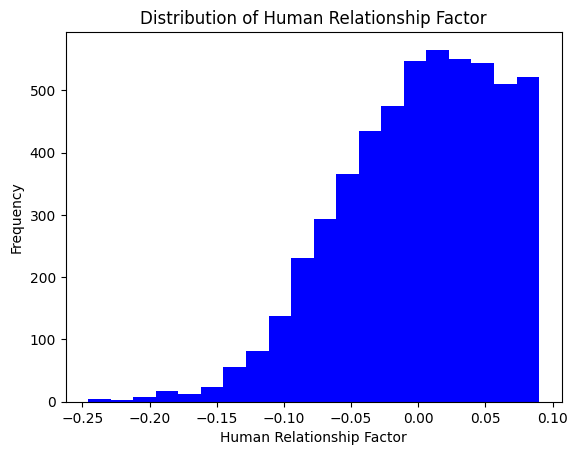

In [402]:
import matplotlib.pyplot as plt

plt.hist(df["human_rel"], bins=20, color='blue')
plt.title("Distribution of Human Relationship Factor")
plt.xlabel("Human Relationship Factor")
plt.ylabel("Frequency")
plt.show()

# 선생 불만 & 학교폭력

In [403]:
school_satis = df[['q082', 'q083', 'q084', 'q085', 'q086']+['q33', 'q351']]

In [404]:
school_satis.isnull().sum()

q082       0
q083       0
q084       0
q085       0
q086       0
q33        0
q351    5207
dtype: int64

In [405]:
df['q085'].value_counts()

q085
경험이 전혀 없거나 거의 없었다    4914
1년에 몇 번 있었다           321
한 달에 몇 번 있었다           94
일주일에 한번 이상 있었다         47
Name: count, dtype: int64

In [406]:
school_satis['q351'] = school_satis['q351'].cat.add_categories([0])
school_satis = null0(school_satis)
school_satis['q351'] = school_satis['q351'].replace(['0', '모름/무응답'], 0).apply(lambda x: 0 if x == 0 else 1)
school_satis = encoding(school_satis, ['q082', 'q083', 'q084', 'q085', 'q086'], how_often_map)
school_satis = encoding(school_satis, ['q33'], how_serious_map)

In [407]:
school_satis.describe(include='all')

,q082,q083,q084,q085,q086,q33,q351
count,5376.0,5376.0,5376.0,5376.0,5376.0,5376.0,5376.000000
unique,3.0,3.0,3.0,3.0,3.0,5.0,NaN
top,2.0,2.0,2.0,2.0,2.0,1.0,NaN
freq,5025.0,4684.0,4988.0,4914.0,4950.0,1670.0,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,0.030134
std,NaN,NaN,NaN,NaN,NaN,NaN,0.170972
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [409]:
model_desc = """
teacher_satis =~ q082 + q083 + q084 + q085 + q086
school_violent =~ q33 + q351
school_satis =~ teacher_satis + school_violent
"""
school_satis['wt'] = df['wt']
observed_vars = ['q082', 'q083', 'q084', 'q085', 'q086']+['q33', 'q351']
w_cov_df = calculate_covariance(school_satis, observed_vars)
vif_df = compute_vif(school_satis, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, school_satis, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)
factor_scores = model.predict_factors(school_satis)

df["school_satis"] = factor_scores["school_satis"]

print(df.head())

적합도 지표:
                      Value
DoF              12.000000
DoF Baseline     21.000000
chi2            570.454276
chi2 p-value      0.000000
chi2 Baseline  9468.953892
CFI               0.940892
GFI               0.939755
AGFI              0.894572
NFI               0.939755
TLI               0.896560
RMSEA             0.093049
AIC              31.787777
BIC             137.222976
LogLik            0.106111 


모수 추정치:
               lval  op            rval  Estimate        Std. Err    z-value  \
0    teacher_satis   ~    school_satis  1.000000               -          -   
1   school_violent   ~    school_satis -0.815002  1847551.356161       -0.0   
2             q082   ~   teacher_satis  1.000000               -          -   
3             q083   ~   teacher_satis  1.605298        0.050799  31.600909   
4             q084   ~   teacher_satis  1.391809        0.041542  33.503933   
5             q085   ~   teacher_satis  1.556473        0.043637  35.668605   
6             q086   

In [408]:
df_rel = df[friend_rel+teacher_rel+parent_rel+group_rel]
df_rel = not_applicable(df_rel, ['q132', 'q136','q171', 'q161', 'q163', 'q164', 'q173', 'q174', 'q224'])
df_rel = encoding(df_rel, ['q05', 'q136','q061','q062','q161','q163','q164','q171','q173','q174','q224','q225'], category5_map)
df_rel = encoding(df_rel, ['q132'], reverse_category5_map)
df_rel = pd.DataFrame(scaler.fit_transform(df_rel), columns=df_rel.columns)
df_rel.head(3)
model_desc = """
friend_rel =~ q132 + q136
teacher_rel =~ q061 + q062
father_rel =~ q161 + q163
mother_rel =~ q171 + q173
group_rel =~ q224 + q225

human_rel =~ friend_rel + teacher_rel + father_rel + mother_rel + group_rel

father_rel ~~ mother_rel
"""
df_rel['wt'] = df['wt']
observed_vars = ['q132', 'q136', 'q061', 'q062', 'q161', 'q163', 'q171','q173', 'q224', 'q225']
w_cov_df = calculate_covariance(df_rel, observed_vars)
vif_df = compute_vif(df_rel, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_rel, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)
factor_scores = model.predict_factors(df_rel)

df["human_rel"] = factor_scores["human_rel"]

print(df.head())

적합도 지표:
                       Value
DoF               29.000000
DoF Baseline      45.000000
chi2             658.209326
chi2 p-value       0.000000
chi2 Baseline  15936.494396
CFI                0.960406
GFI                0.958698
AGFI               0.935911
NFI                0.958698
TLI                0.938561
RMSEA              0.063534
AIC               51.755130
BIC              223.087327
LogLik             0.122435 


모수 추정치:
            lval  op         rval  Estimate  Std. Err    z-value p-value
0    friend_rel   ~    human_rel  1.000000         -          -       -
1   teacher_rel   ~    human_rel  1.794071  0.103989  17.252581     0.0
2    father_rel   ~    human_rel  1.290233  0.083021  15.541102     0.0
3    mother_rel   ~    human_rel  1.052752  0.066343  15.868427     0.0
4     group_rel   ~    human_rel  2.194070   0.13792  15.908298     0.0
5          q132   ~   friend_rel  1.000000         -          -       -
6          q136   ~   friend_rel  1.363978  0.082112   